# 1. Quá trình dự báo trên mô hình LR

## Thêm thư viện

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
# from sklearn.utils import column_or_1d
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

In [3]:
# Load data
df = pd.read_csv('xrp.csv')
print(df)
name_col='close'

      Unnamed: 0 formatted_date      high       low      open     close  \
0              0     2019-01-01  0.364771  0.350402  0.365675  0.364771   
1              1     2019-01-02  0.378021  0.359574  0.374505  0.375243   
2              2     2019-01-03  0.374505  0.357675  0.359753  0.360224   
3              3     2019-01-04  0.364642  0.352785  0.356347  0.356747   
4              4     2019-01-05  0.361069  0.353987  0.354750  0.355275   
...          ...            ...       ...       ...       ...       ...   
1515        1515     2023-02-24  0.390547  0.374133  0.378507  0.378477   
1516        1516     2023-02-25  0.379419  0.372250  0.378085  0.378085   
1517        1517     2023-02-26  0.380606  0.375420  0.378005  0.378041   
1518        1518     2023-02-27  0.380042  0.372158  0.379121  0.379115   
1519        1519     2023-02-28  0.382433  0.373027  0.377133  0.377150   

          volume  adjclose  
0      449347622  0.364771  
1      543216669  0.375243  
2      43887

In [4]:
# Process data
df['H-L'] = df['high'] - df['low']
# df['O-C'] = df['open'] - df['close']
ma_1 = 7
ma_2 = 14
ma_3 = 21
df[f'SMA_{ma_1}'] = df[name_col].rolling(window=ma_1).mean()
df[f'SMA_{ma_2}'] = df[name_col].rolling(window=ma_2).mean()
df[f'SMA_{ma_3}'] = df[name_col].rolling(window=ma_3).mean()

df[f'SD_{ma_1}'] = df[name_col].rolling(window=ma_1).std()
df[f'SD_{ma_3}'] = df[name_col].rolling(window=ma_3).std()
df.dropna(inplace=True)

# df.to_csv(f"../../predict/bitcoin_df_{name_col}.csv")
df.set_index('formatted_date')
df2=df.copy()

## Nạp dữ liệu từ file csv

In [5]:

split_x = df2[['high','low','open','H-L', f'SMA_{ma_1}', f'SMA_{ma_2}', f'SMA_{ma_3}', f'SD_{ma_1}', f'SD_{ma_3}','formatted_date']]
split_y = df2[[name_col]]

X_train, X_test,y_train, y_test = train_test_split(split_x,split_y ,
                                   random_state=104, 
                                   test_size=0.1, 
                                   shuffle=True)
print(X_train)

          high       low      open       H-L     SMA_7    SMA_14    SMA_21  \
1478  0.395209  0.371321  0.379419  0.023888  0.385009  0.367294  0.359469   
1325  0.380862  0.370915  0.370969  0.009947  0.376870  0.376232  0.376064   
349   0.218908  0.206862  0.207189  0.012046  0.218593  0.221367  0.222502   
564   0.201602  0.193937  0.199404  0.007665  0.197529  0.195752  0.189552   
680   0.259724  0.252842  0.256258  0.006882  0.252666  0.245886  0.248152   
...        ...       ...       ...       ...       ...       ...       ...   
186   0.408374  0.378463  0.389503  0.029911  0.395535  0.422018  0.428438   
674   0.247046  0.237558  0.245770  0.009488  0.239604  0.245107  0.245383   
1295  0.375989  0.352916  0.373257  0.023073  0.346452  0.338413  0.333494   
749   0.326188  0.283997  0.294219  0.042191  0.288297  0.296035  0.272597   
89    0.311171  0.308150  0.309195  0.003021  0.308374  0.311468  0.312477   

          SD_7     SD_21 formatted_date  
1478  0.006409  0.020

## Chuẩn hóa dữ liệu

In [6]:
cols_x = ['high','low','open','H-L', f'SMA_{ma_1}', f'SMA_{ma_2}', f'SMA_{ma_3}', f'SD_{ma_1}', f'SD_{ma_3}']
cols_y = [name_col]
x_train = X_train[cols_x].values.reshape(-1, len(cols_x))
y_train = y_train[cols_y].values.reshape(-1, len(cols_y))
print(x_train.shape, y_train.shape)

(1350, 9) (1350, 1)


In [7]:

x_test = X_test[cols_x].values.reshape(-1, len(cols_x))
y_test = y_test[cols_y].values.reshape(-1, len(cols_y))
print(x_test.shape, y_test.shape)

(150, 9) (150, 1)


# 2. Quá trình dự đoán trên mô hình 


In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor

In [9]:
_gdm = ('gradient', GradientBoostingRegressor(learning_rate= 0.07, max_depth= 8, n_estimators= 1000, subsample= 0.3));
_elm = ('elasticnet', ElasticNet(alpha= 0.01, l1_ratio= 0.8, positive= True, random_state= 100, selection= 'random', tol= 0.2, warm_start= True));
_lsm = ('lasso', Lasso(alpha= 3.17, copy_X= True, fit_intercept= False, max_iter= 1, normalize= True, positive= False, precompute= False, random_state= None, selection= 'random', tol= 0.3, warm_start= False));
_ridge = ('ridge',Ridge(alpha= 0.0006, copy_X= True, fit_intercept= False, max_iter= 1, normalize= False, positive= True, random_state= None, solver= 'auto', tol= 0.001));
_lr = ('linear',LinearRegression())

In [10]:
from itertools import permutations 
perm = permutations([_lr, _gdm, _lsm, _ridge]) 
_estimator_elm = []
for i in list(perm): 
    _estimator_elm.append(i)

In [11]:
parameters = {'estimators':_estimator_elm,  
              'final_estimator':_elm}
elm_grid = GridSearchCV(StackingRegressor(estimators= None, final_estimator = None),parameters, scoring='r2', cv=None).fit(x_train, y_train.reshape(-1, 1))
print(elm_grid.best_params_)
elm_reg = StackingRegressor(estimators= elm_grid.best_params_["estimators"], final_estimator = elm_grid.best_params_["final_estimator"])
elm_reg.fit(x_train, y_train.reshape(-1, 1))
elm_pred = elm_reg.predict(x_test)

{'estimators': (('gradient', GradientBoostingRegressor(learning_rate=0.07, max_depth=8, n_estimators=1000,
                          subsample=0.3)), ('lasso', Lasso(alpha=3.17, fit_intercept=False, max_iter=1, normalize=True,
      selection='random', tol=0.3)), ('linear', LinearRegression()), ('ridge', Ridge(alpha=0.0006, fit_intercept=False, max_iter=1, normalize=False,
      positive=True))), 'final_estimator': ElasticNet(alpha=0.01, l1_ratio=0.8, positive=True, random_state=100,
           selection='random', tol=0.2, warm_start=True)}


,high,low,open,H-L,SMA_7,SMA_14,SMA_21,SD_7,SD_21,formatted_date,predict
801,0.463694,0.433015,0.441109,0.030679,0.464116,0.455761,0.467919,0.014321,0.038535,2021-03-12,0.445197
1159,0.766085,0.707479,0.754923,0.058606,0.753879,0.742617,0.765528,0.027945,0.045225,2022-03-05,0.733258
1506,0.401862,0.377248,0.401348,0.024614,0.382834,0.393343,0.398403,0.009365,0.013717,2023-02-15,0.408251
902,0.779790,0.605175,0.607232,0.174615,0.787033,0.830816,0.876765,0.089076,0.098236,2021-06-21,0.599918
224,0.301178,0.293562,0.296719,0.007616,0.302081,0.309805,0.311595,0.005706,0.008413,2019-08-13,0.312303


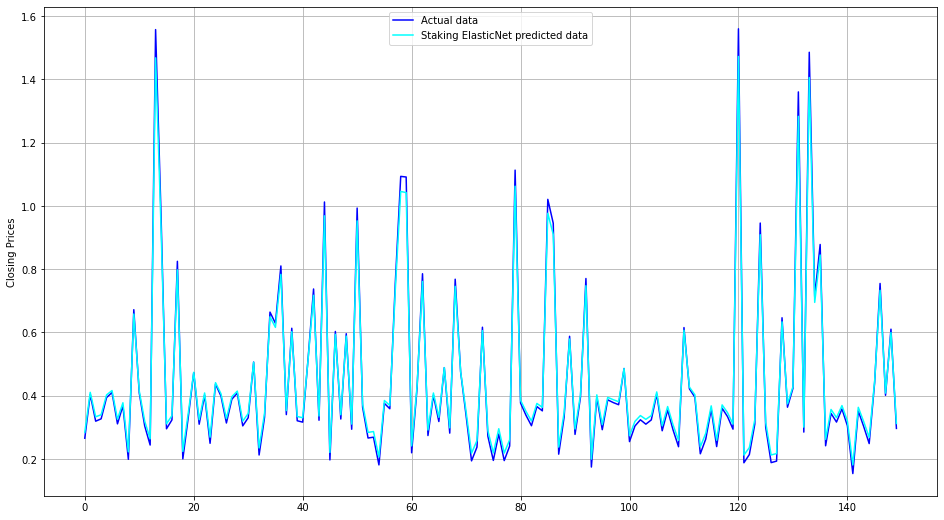

In [12]:

plt.figure(figsize=(16, 9))
plt.grid(True)
plt.ylabel('Closing Prices')
plt.plot(y_test, 'blue', label='Actual data')
plt.plot(elm_pred, 'cyan', label='Staking ElasticNet predicted data')
plt.legend()
X_test['predict']=elm_pred
X_test.tail()

In [13]:
import pickle


In [14]:
mae = mean_absolute_error(y_test, elm_pred)
mape = mean_absolute_percentage_error(y_test, elm_pred)
mse = mean_squared_error(y_test, elm_pred)
rmse = np.sqrt(mse)
# r2 = r2_score(y_test, elm_pred)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
# print(f"R2: {r2:.2f}")

MAE: 0.02
MAPE: 4.71%
MSE: 0.00
RMSE: 0.02
